# **Análise de Dados - Hipertensão**

## Importando as bibliotecas necessárias

In [ ]:
!pip install pycaret

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files



## Importando os dados

In [5]:
uploaded = files.upload()

Saving demographic.csv to demographic.csv
Saving diet.csv to diet.csv
Saving examination.csv to examination.csv
Saving labs.csv to labs.csv
Saving medications.csv to medications.csv
Saving questionnaire.csv to questionnaire.csv


## Juntando os datasets

In [6]:
## dataset 'medications' == 'questionnaire'
demo = pd.read_csv('demographic.csv')
diet = pd.read_csv('diet.csv')
exam = pd.read_csv('examination.csv')
labs = pd.read_csv('labs.csv')
quest = pd.read_csv('questionnaire.csv')


In [7]:
demo.drop(['SEQN'], axis=1, inplace=True)
diet.drop(['SEQN'], axis=1, inplace=True)
exam.drop(['SEQN'], axis=1, inplace=True)
labs.drop(['SEQN'], axis=1, inplace=True)
quest.drop(['SEQN'], axis=1, inplace=True)

In [8]:
df = pd.concat([demo, diet, exam, labs, quest], axis=1, join='inner')


In [9]:
df.head()

,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,DMQMILIZ,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,8,2,1,69,NaN,4,4,1.0,NaN,1.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,8,2,1,54,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,8,2,1,72,NaN,3,3,2.0,NaN,1.0,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,8,2,1,9,NaN,3,3,1.0,119.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,8,2,2,73,NaN,3,3,1.0,NaN,2.0,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN


In [10]:
df.shape

(9813, 1811)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9813 entries, 0 to 9812
Columns: 1811 entries, SDDSRVYR to WHQ520
dtypes: float64(1753), int64(27), object(31)
memory usage: 135.6+ MB


## Eliminando colunas 'duplicadas' que servem apenas para conversão de unidades

In [12]:
cols = [c for c in df.columns if c[-2:]!= 'SI']

## Definindo as colunas que serão usadas

In [13]:
## hipertensão (blood pressure)
df = df[['ALQ101', 'BMXBMI', 'BMXWT', 'BPQ020', 'BPQ080', 'BPXSY1', 'BPXDI1', 'HSD010', 'LBXMC', 'MCQ160B', 'MCQ160C', 'MCQ160D', 'MCQ160E', 'MCQ160F', 'MCQ300A', 'MCQ370B', 'PEASCST1', 'RIAGENDR', 'RIDAGEYR', 'WHD010', 'SMQ040']]


# Dicionário de Features

In [14]:
col_decoder = {
'ALQ101' : 'Drink_alcohol',             # Drink_Alcohol - Had at least 12 alcohol drinks/1 yr? ------ 0 = no  1 = yes      
'BMXBMI' : 'BMI',                       # BMI      - Body Mass Index / 
'BMXWT' : 'Weight_kg',                  # Weight in Kilograms 
'BPQ020' : 'HighBP',                   # HighBP   - High Blood Pressure  ------  0 = no high BP 1 = high BP
'BPQ080' : 'HighChol',          # HighCholesterol - High Cholesterol ----------- 0 = no high cholesterol  1 = high cholesterol
'BPXSY1' : 'Systolic_bp',               # Systolic: Blood pres (1st rdg) mm Hg 
'BPXDI1' : 'Diastolic_bp',              # Diastolic: Blood pres (1st rdg) mm Hg
'HSD010' : 'GenHlth',            # General Health Condition ------ 1 = Excelent  2 = Very good  3 = Good  4 = Fair  5 = Poor   
'LBXMC' : 'Hemoglobin_concentration',   # Mean cell hemoglobin concentration (g/dL)
'MCQ160B' : 'Congestive_heart_failure', # Ever told had congestive heart failure ------  0 = no  1 = yes
'MCQ160C' : 'Coronary_heart_disease',   # Ever told you had coronary heart disease ------  0 = no  1 = yes
'MCQ160D' : 'Angina',                   # Ever told you had angina/angina pectoris ------  0 = no  1 = yes
'MCQ160E' : 'Heart_attack',             # Ever told you had heart attack ------  0 = no  1 = yes 
'MCQ160F' : 'Stroke',                   # Ever told you had a stroke ------ 0 = no 1 = yes
'MCQ300A' : 'Relative_heart_attack',    # Close relative had heart attack ------  0 = no  1 = yes
'MCQ370B' : 'Exercising',               # Are you now increasing exercise ------  0 = no  1 = yes
'PEASCST1' : 'BP_status',               # Blood Pressure Status ------ 0 = parcial  1 = complete  3 = not done     
'RIAGENDR' : 'Sex',                  # Gender - 0 = female 1 = male
'RIDAGEYR' : 'Age',                     # Age - 13-level age category  1 = 18-24    9 = 60-64    13 = 80 or older
'SMQ040' : 'Smoker',                   # Smoking - 
'WHD010' : 'Height_cm',                 # Height in Centimeters
}

In [15]:
df = df.rename(columns = col_decoder)

## Convertendo dados para as medidas corretas

In [16]:
df['Height_cm'] = df['Height_cm'] * 2.54

In [17]:
df.head()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Diastolic_bp,GenHlth,Hemoglobin_concentration,Congestive_heart_failure,...,Angina,Heart_attack,Stroke,Relative_heart_attack,Exercising,BP_status,Sex,Age,Height_cm,Smoker
0,1.0,26.7,78.3,1.0,1.0,122.0,72.0,2.0,33.4,2.0,...,2.0,2.0,1.0,2.0,2.0,1,1,69,175.26,3.0
1,1.0,28.6,89.5,1.0,1.0,156.0,62.0,4.0,32.5,2.0,...,2.0,2.0,2.0,2.0,2.0,1,1,54,180.34,2.0
2,1.0,28.9,88.9,1.0,1.0,140.0,90.0,3.0,34.3,2.0,...,2.0,2.0,2.0,1.0,2.0,1,1,72,177.80,3.0
3,NaN,17.1,32.2,NaN,NaN,108.0,38.0,NaN,34.0,NaN,...,NaN,NaN,NaN,NaN,NaN,1,1,9,NaN,NaN
4,1.0,19.7,52.0,1.0,2.0,136.0,86.0,5.0,33.0,2.0,...,2.0,2.0,2.0,1.0,2.0,1,2,73,170.18,NaN


## Lidando com Nulls

In [18]:
## Quando o paciente se recusa a responder uma questão ou quando 'não se aplica', são usadas combinações de números 7 e 9
df.replace({7:None, 9:None, 77:None, 99:None, 777:None, 999:None, 7777:None, 9999:None, 77777:None, 99999:None, 777777:None, 999999:None, 55:None, 555:None, 5555:None, 8:None, 88:None}, inplace=True)


In [19]:
df = df.dropna()

In [20]:
df.nunique()

Drink_alcohol                 2
BMI                         314
Weight_kg                   685
HighBP                        2
HighChol                      2
Systolic_bp                  56
Diastolic_bp                 45
GenHlth                       5
Hemoglobin_concentration     60
Congestive_heart_failure      2
Coronary_heart_disease        2
Angina                        2
Heart_attack                  2
Stroke                        2
Relative_heart_attack         2
Exercising                    2
BP_status                     1
Sex                           2
Age                          59
Height_cm                    26
Smoker                        3
dtype: int64

In [21]:
df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure', 'Coronary_heart_disease',	'Angina',	'Heart_attack',	'Stroke',	'Relative_heart_attack',	'Exercising',	'BP_status']] = df[['Drink_alcohol',	'HighBP',	'HighChol',	'Congestive_heart_failure', 'Coronary_heart_disease',	'Angina',	'Heart_attack',	'Stroke',	'Relative_heart_attack',	'Exercising',	'BP_status']].replace(2.0,0)

In [22]:
df.head()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Diastolic_bp,GenHlth,Hemoglobin_concentration,Congestive_heart_failure,...,Angina,Heart_attack,Stroke,Relative_heart_attack,Exercising,BP_status,Sex,Age,Height_cm,Smoker
0,1.0,26.7,78.3,1.0,1.0,122.0,72.0,2.0,33.4,0.0,...,0.0,0.0,1.0,0.0,0.0,1,1,69.0,175.26,3.0
1,1.0,28.6,89.5,1.0,1.0,156.0,62.0,4.0,32.5,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,54.0,180.34,2.0
2,1.0,28.9,88.9,1.0,1.0,140.0,90.0,3.0,34.3,0.0,...,0.0,0.0,0.0,1.0,0.0,1,1,72.0,177.80,3.0
5,1.0,41.7,105.0,1.0,1.0,160.0,84.0,5.0,34.2,0.0,...,0.0,1.0,0.0,0.0,1.0,1,1,56.0,162.56,3.0
9,1.0,22.0,65.3,0.0,0.0,140.0,78.0,3.0,35.3,0.0,...,0.0,0.0,0.0,0.0,1.0,1,2,56.0,154.94,1.0


## Removendo linhas e colunas com grande quantidade de nulls

In [23]:
def filter_columns(df, cutoff=0.9):
    tot_rows = df.shape[0]
    removed_cols = []
   
    for col in df.columns:
        num_na = df[col].isna().sum()
        if (num_na/tot_rows) > cutoff:
            removed_cols.append(col)
    return df.drop(removed_cols, axis=1)
    
def filter_rows(df, cutoff=0.9):
    tot_cols = df.shape[1]
    df = df[df.isnull().sum(axis=1) < tot_cols*cutoff]
    return df

In [24]:
df.isnull().sum()

Drink_alcohol               0
BMI                         0
Weight_kg                   0
HighBP                      0
HighChol                    0
Systolic_bp                 0
Diastolic_bp                0
GenHlth                     0
Hemoglobin_concentration    0
Congestive_heart_failure    0
Coronary_heart_disease      0
Angina                      0
Heart_attack                0
Stroke                      0
Relative_heart_attack       0
Exercising                  0
BP_status                   0
Sex                         0
Age                         0
Height_cm                   0
Smoker                      0
dtype: int64

In [25]:
df = df[df['Age'] > 18]

In [26]:
df.shape

(1314, 21)

In [27]:
df.sample(10)

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Diastolic_bp,GenHlth,Hemoglobin_concentration,Congestive_heart_failure,...,Angina,Heart_attack,Stroke,Relative_heart_attack,Exercising,BP_status,Sex,Age,Height_cm,Smoker
3387,1.0,34.0,88.5,0.0,0.0,100.0,70.0,4.0,34.8,0.0,...,0.0,0.0,0.0,0.0,1.0,1,1,64.0,172.72,3.0
6665,0.0,19.8,41.2,1.0,0.0,100.0,58.0,4.0,33.6,0.0,...,0.0,1.0,0.0,1.0,0.0,1,2,57.0,152.40,1.0
2164,0.0,30.6,87.9,0.0,1.0,142.0,70.0,1.0,33.9,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,32.0,172.72,3.0
3895,1.0,50.7,158.5,0.0,0.0,138.0,94.0,5.0,34.8,0.0,...,0.0,0.0,0.0,0.0,1.0,1,1,27.0,167.64,3.0
2138,1.0,21.4,38.9,1.0,0.0,86.0,46.0,4.0,34.8,0.0,...,0.0,0.0,0.0,0.0,0.0,1,2,74.0,160.02,3.0
0,1.0,26.7,78.3,1.0,1.0,122.0,72.0,2.0,33.4,0.0,...,0.0,0.0,1.0,0.0,0.0,1,1,69.0,175.26,3.0
1261,1.0,27.0,72.8,0.0,0.0,104.0,62.0,2.0,31.8,0.0,...,0.0,0.0,0.0,0.0,0.0,1,1,26.0,175.26,3.0
7033,1.0,20.3,32.5,0.0,1.0,96.0,68.0,3.0,33.2,0.0,...,1.0,1.0,0.0,0.0,1.0,1,2,43.0,165.10,1.0
3039,1.0,43.7,118.5,1.0,0.0,134.0,94.0,4.0,33.7,0.0,...,0.0,0.0,0.0,1.0,0.0,1,2,46.0,157.48,3.0
7332,1.0,21.8,56.0,1.0,1.0,170.0,70.0,5.0,33.6,0.0,...,0.0,1.0,0.0,0.0,0.0,1,1,80.0,175.26,3.0


In [28]:
df.describe()

,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Diastolic_bp,GenHlth,Hemoglobin_concentration,Congestive_heart_failure,...,Angina,Heart_attack,Stroke,Relative_heart_attack,Exercising,BP_status,Sex,Age,Height_cm,Smoker
count,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,...,1314.000000,1314.000000,1314.000000,1314.000000,1314.000000,1314.0,1314.000000,1314.000000,1314.000000,1314.000000
mean,0.867580,27.314307,74.719787,0.418569,0.388128,118.543379,65.919330,2.953577,33.814155,0.038052,...,0.035008,0.060883,0.044140,0.140791,0.558600,1.0,1.429224,50.957382,342.965723,2.188737
std,0.339076,7.444358,24.604097,0.493512,0.487509,18.184466,14.728915,0.980452,1.372967,0.191394,...,0.183869,0.239206,0.205484,0.347939,0.496743,0.0,0.495154,17.105996,2081.479172,0.934729
min,0.000000,13.200000,19.500000,0.000000,0.000000,74.000000,0.000000,1.000000,29.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,20.000000,137.160000,1.000000
25%,1.000000,22.400000,59.300000,0.000000,0.000000,106.000000,58.000000,2.000000,33.200000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.000000,36.000000,162.560000,1.000000
50%,1.000000,26.300000,73.500000,0.000000,0.000000,116.000000,68.000000,3.000000,33.800000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,1.000000,52.000000,170.180000,3.000000
75%,1.000000,31.075000,88.400000,1.000000,1.000000,128.000000,74.000000,4.000000,34.500000,0.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.0,2.000000,64.750000,177.800000,3.000000
max,1.000000,70.100000,184.500000,1.000000,1.000000,220.000000,110.000000,5.000000,69.600000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,2.000000,80.000000,25397.460000,3.000000


# Machine Learning e seleção do melhor modelo

In [29]:
from pycaret.classification import *

/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [31]:
cat_features = ['Sex', 'Age'] 

## inserir depois, em SETUP -> ,categorical_features=cat_features

In [33]:
s = setup(data = df, target='HighBP', train_size=0.75, categorical_features=cat_features)

,Description,Value
0,session_id,6333
1,Target,HighBP
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(1314, 21)"
5,Missing Values,False
6,Numeric Features,8
7,Categorical Features,12
8,Ordinal Features,False
9,High Cardinality Features,False


In [34]:
best = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
ridge,Ridge Classifier,0.6750,0.0000,0.5754,0.6504,0.6087,0.3325,0.3361,0.016
lr,Logistic Regression,0.6740,0.7359,0.5405,0.6581,0.5918,0.3248,0.3307,0.783
lda,Linear Discriminant Analysis,0.6730,0.7393,0.5707,0.6473,0.6052,0.3278,0.3311,0.031
rf,Random Forest Classifier,0.6710,0.7288,0.5337,0.6577,0.5846,0.3179,0.3256,0.581
gbc,Gradient Boosting Classifier,0.6588,0.7193,0.5382,0.6339,0.5795,0.2958,0.3007,0.238
ada,Ada Boost Classifier,0.6578,0.7058,0.5615,0.6236,0.5880,0.2974,0.3008,0.150
et,Extra Trees Classifier,0.6559,0.7146,0.5892,0.6106,0.5961,0.2972,0.2998,0.531
nb,Naive Bayes,0.6497,0.7187,0.6776,0.5898,0.6283,0.3009,0.3054,0.024
lightgbm,Light Gradient Boosting Machine,0.6214,0.6687,0.4992,0.5822,0.5332,0.2190,0.2231,0.120
dt,Decision Tree Classifier,0.6141,0.6053,0.5339,0.5667,0.5456,0.2119,0.2142,0.024


In [35]:
model = create_model('lr', fold = 5)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7107,0.7597,0.5862,0.7083,0.6415,0.4026,0.4076
1,0.6954,0.7301,0.5349,0.6970,0.6053,0.3642,0.3727
2,0.6853,0.7422,0.5465,0.6714,0.6026,0.3466,0.3516
3,0.6345,0.7299,0.5930,0.5795,0.5862,0.2590,0.2591
4,0.6396,0.7283,0.5000,0.6056,0.5478,0.2527,0.2559
Mean,0.6731,0.7380,0.5521,0.6524,0.5967,0.3250,0.3294
Std,0.0306,0.0119,0.0343,0.0509,0.0304,0.0593,0.0614


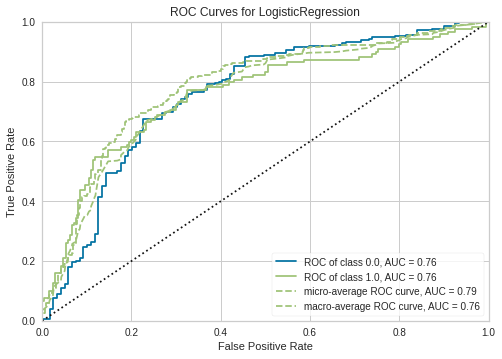

In [36]:
plot_model(model)

In [37]:
plot_model(model, 'confusion matrix')

ValueError: ignored

In [39]:
tuned_lr = tune_model(model
                      ,fold = 5
                      ,optimize = 'AUC')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6853,0.7524,0.6437,0.6437,0.6437,0.3619,0.3619
1,0.6650,0.7165,0.5698,0.6282,0.5976,0.3118,0.3129
2,0.6650,0.7510,0.5698,0.6282,0.5976,0.3118,0.3129
3,0.6294,0.7327,0.6512,0.5657,0.6054,0.2594,0.2616
4,0.6396,0.7210,0.5930,0.5862,0.5896,0.2683,0.2684
Mean,0.6569,0.7347,0.6055,0.6104,0.6068,0.3026,0.3035
Std,0.0199,0.0148,0.0354,0.0294,0.0191,0.0367,0.0362


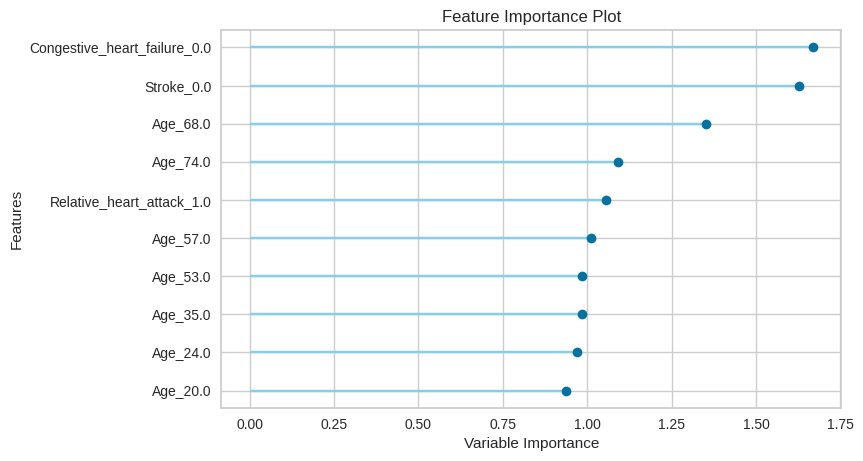

In [40]:
plot_model(estimator = tuned_lr, plot = 'feature')

In [41]:
predict_model(model, data=df)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7146,0.7849,0.5818,0.6882,0.6305,0.4007,0.4044


,Drink_alcohol,BMI,Weight_kg,HighBP,HighChol,Systolic_bp,Diastolic_bp,GenHlth,Hemoglobin_concentration,Congestive_heart_failure,...,Stroke,Relative_heart_attack,Exercising,BP_status,Sex,Age,Height_cm,Smoker,Label,Score
0,1.0,26.7,78.3,1.0,1.0,122.0,72.0,2.0,33.4,0.0,...,1.0,0.0,0.0,1,1,69.0,175.26,3.0,1.0,0.7053
1,1.0,28.6,89.5,1.0,1.0,156.0,62.0,4.0,32.5,0.0,...,0.0,0.0,0.0,1,1,54.0,180.34,2.0,1.0,0.5706
2,1.0,28.9,88.9,1.0,1.0,140.0,90.0,3.0,34.3,0.0,...,0.0,1.0,0.0,1,1,72.0,177.80,3.0,1.0,0.7817
5,1.0,41.7,105.0,1.0,1.0,160.0,84.0,5.0,34.2,0.0,...,0.0,0.0,1.0,1,1,56.0,162.56,3.0,1.0,0.7913
9,1.0,22.0,65.3,0.0,0.0,140.0,78.0,3.0,35.3,0.0,...,0.0,0.0,1.0,1,2,56.0,154.94,1.0,0.0,0.7527
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9788,1.0,22.5,57.7,0.0,1.0,106.0,54.0,4.0,34.9,0.0,...,0.0,1.0,0.0,1,1,54.0,185.42,3.0,1.0,0.8086
9790,1.0,24.3,71.7,0.0,1.0,116.0,62.0,3.0,34.3,0.0,...,0.0,1.0,0.0,1,2,80.0,170.18,3.0,1.0,0.8569
9794,1.0,23.7,62.5,0.0,1.0,118.0,66.0,4.0,31.2,0.0,...,0.0,1.0,0.0,1,1,63.0,177.80,3.0,1.0,0.7972
9799,1.0,27.4,74.7,0.0,0.0,114.0,72.0,3.0,33.7,0.0,...,0.0,0.0,0.0,1,2,21.0,157.48,1.0,0.0,0.8372


In [42]:
final = finalize_model(model)

In [43]:
saved = save_model(final, 'model')

Transformation Pipeline and Model Successfully Saved


In [49]:
my_model = load_model('data/model')

Transformation Pipeline and Model Successfully Loaded


In [50]:
data_teste = pd.DataFrame()
data_teste['HighBP'] = [1]  
data_teste['HighChol'] = [1]
data_teste['BMI'] = [31]
data_teste['Smoker'] = [1] 
data_teste['Stroke'] = [1]
data_teste['HeartDiseaseorAttack'] = [1] 
data_teste['Fruits'] = [0] 
data_teste['Veggies'] = [0]
data_teste['HvyAlcoholConsump'] = [1]
data_teste['GenHlth'] = [5]
data_teste['Sex'] = [1]
data_teste['Age'] = [13]
data_teste['Drink_alcohol'] = [1]
data_teste['Weight_kg'] = [100]
data_teste['Systolic_bp'] = [135]
data_teste['Diastolic_bp'] = [60]
data_teste['Hemoglobin_concentration'] = [32]
data_teste['Congestive_heart_failure'] = [0]
data_teste['Coronary_heart_disease'] = [0]
data_teste['Angina'] = [0]
data_teste['Heart_attack'] = [0]
data_teste['Relative_heart_attack'] = [1]
data_teste['Exercising'] = [0]
data_teste['BP_status'] = [1]
data_teste['Height_cm'] = [180]

#realiza a predição.
result = predict_model(my_model, data=data_teste)

#recupera os resultados.
classe = result["Label"][0]
prob = result["Score"][0]*100

print(classe)
print(prob)


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,1.0,0,1.0,1.0,1.0,NaN,0.0


1.0
94.77
